<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - West Nile Virus Prediction (Kaggle) <br> [Part 2 of 4]

_Prepared by: Kho Guan Guo, Soh Sze Ron, Timothy Chan, 3 Apr 2023_

## Contents:
- [EDA](#EDA)
- [Summary](#Summary)

**Part 2** consists of EDA.

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from matplotlib.lines import Line2D

In [2]:
df_train = pd.read_csv('../data/data_cleaned/train_clean.csv', parse_dates=True)
df_test = pd.read_csv('../data/data_cleaned/test_clean.csv', parse_dates=True)
df_spray = pd.read_csv('../data/data_cleaned/spray_clean.csv', parse_dates=True)
mapdata = np.loadtxt('../data/data_cleaned/mapdata_copyright_openstreetmap_contributors.txt')

---
## EDA
---

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8475 non-null   object 
 1   species                    8475 non-null   object 
 2   trap                       8475 non-null   object 
 3   address_number_and_street  8475 non-null   object 
 4   latitude                   8475 non-null   float64
 5   longitude                  8475 non-null   float64
 6   num_mosquitos              8475 non-null   int64  
 7   wnv_present                8475 non-null   int64  
 8   station                    8475 non-null   int64  
 9   tmax                       8475 non-null   int64  
 10  tmin                       8475 non-null   int64  
 11  tavg                       8475 non-null   int64  
 12  depart                     8475 non-null   int64  
 13  dew_point                  8475 non-null   int64

0    0.946077
1    0.053923
Name: wnv_present, dtype: float64

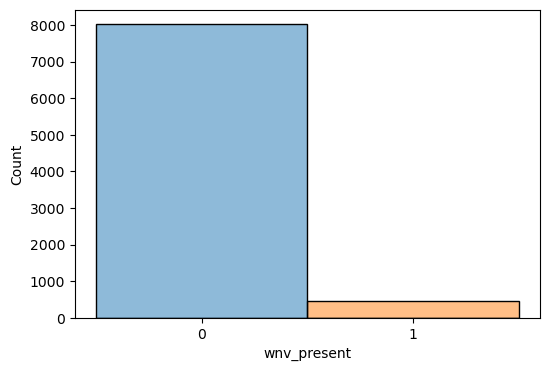

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(df_train, x='wnv_present', discrete=True, hue='wnv_present', legend=False)
plt.xticks([0, 1]);

df_train['wnv_present'].value_counts(normalize=True)

Heavily imbalanced dataset. Need to perform preprocessing later

**Correlation**

In [5]:
# Spearman Correlation to 'wnv_present', 'num_mosquitos'; filter to exclude those with low correlation
corr_wnv_present = round(df_train.corr(method='spearman')['wnv_present'], 2)
filtered_corr_wnv_present = corr_wnv_present[(corr_wnv_present >= 0.05) | (corr_wnv_present <= -0.05)].sort_values(ascending=False)

corr_num_mosquitos = round(df_train.corr(method='spearman')['num_mosquitos'], 2)
filtered_num_mosquitos = corr_num_mosquitos[(corr_num_mosquitos >= 0.05) | (corr_num_mosquitos <= -0.05)].sort_values(ascending=False)

# Join into table
corr_comb = pd.concat([filtered_corr_wnv_present, filtered_num_mosquitos], axis=1)
corr_comb.replace(np.nan, 'low corr', inplace=True)
corr_comb

wnv_present num_mosquitos
wnv_present               1.0          0.26
num_mosquitos            0.26           1.0
sunrise                  0.11      low corr
week_number              0.11      low corr
dew_point                 0.1           0.1
month                     0.1      low corr
wet_bulb                 0.09          0.11
tmin                     0.08          0.11
tavg                     0.08          0.11
depart                   0.07          0.06
tmax                     0.05          0.07
result_speed            -0.06      low corr
longitude               -0.07         -0.08
sunset                  -0.11      low corr
minutes_between         -0.11      low corr
year                 low corr          0.15
relative_humidity    low corr         -0.05

In [6]:
selected_num_features = df_train[['wnv_present','num_mosquitos',
                               'sunrise','sunset',
                               'dew_point','wet_bulb',
                               'tmin', 'tavg', 'tmax', 'depart',
                               'year', 'month', 'week_number', 'minutes_between',
                               'result_speed', 'longitude', 'relative_humidity'                               
                              ]]

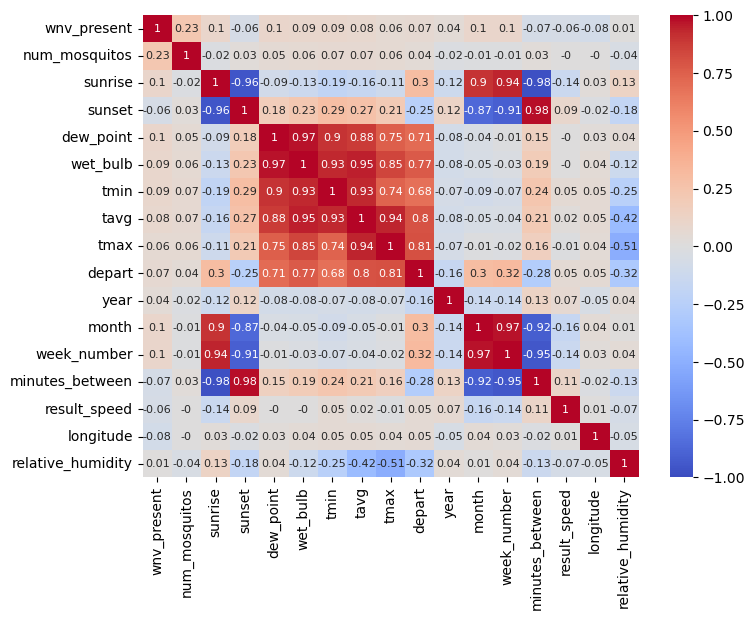

In [7]:
# Correlation heatmap of selected numerical features
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(round(selected_num_features.corr(),2), annot=True, annot_kws={"fontsize":8}, vmin=-1, vmax=1, cmap='coolwarm', ax=ax);

Sunrise, sunset times negatively correlated. Daylight duration is positive related to sunrise and negatively related to sunset (in summer, sun rises earlier and sets later). 

Sunrise positively correlated to month; sunset negatively correlated to month; daylight duration negatively related to month. 

Temperature related (dew_point, wet_bulb, tmin, tavg, tmax, depart) all highly correlated to each other. To only choose one of them as a feature.

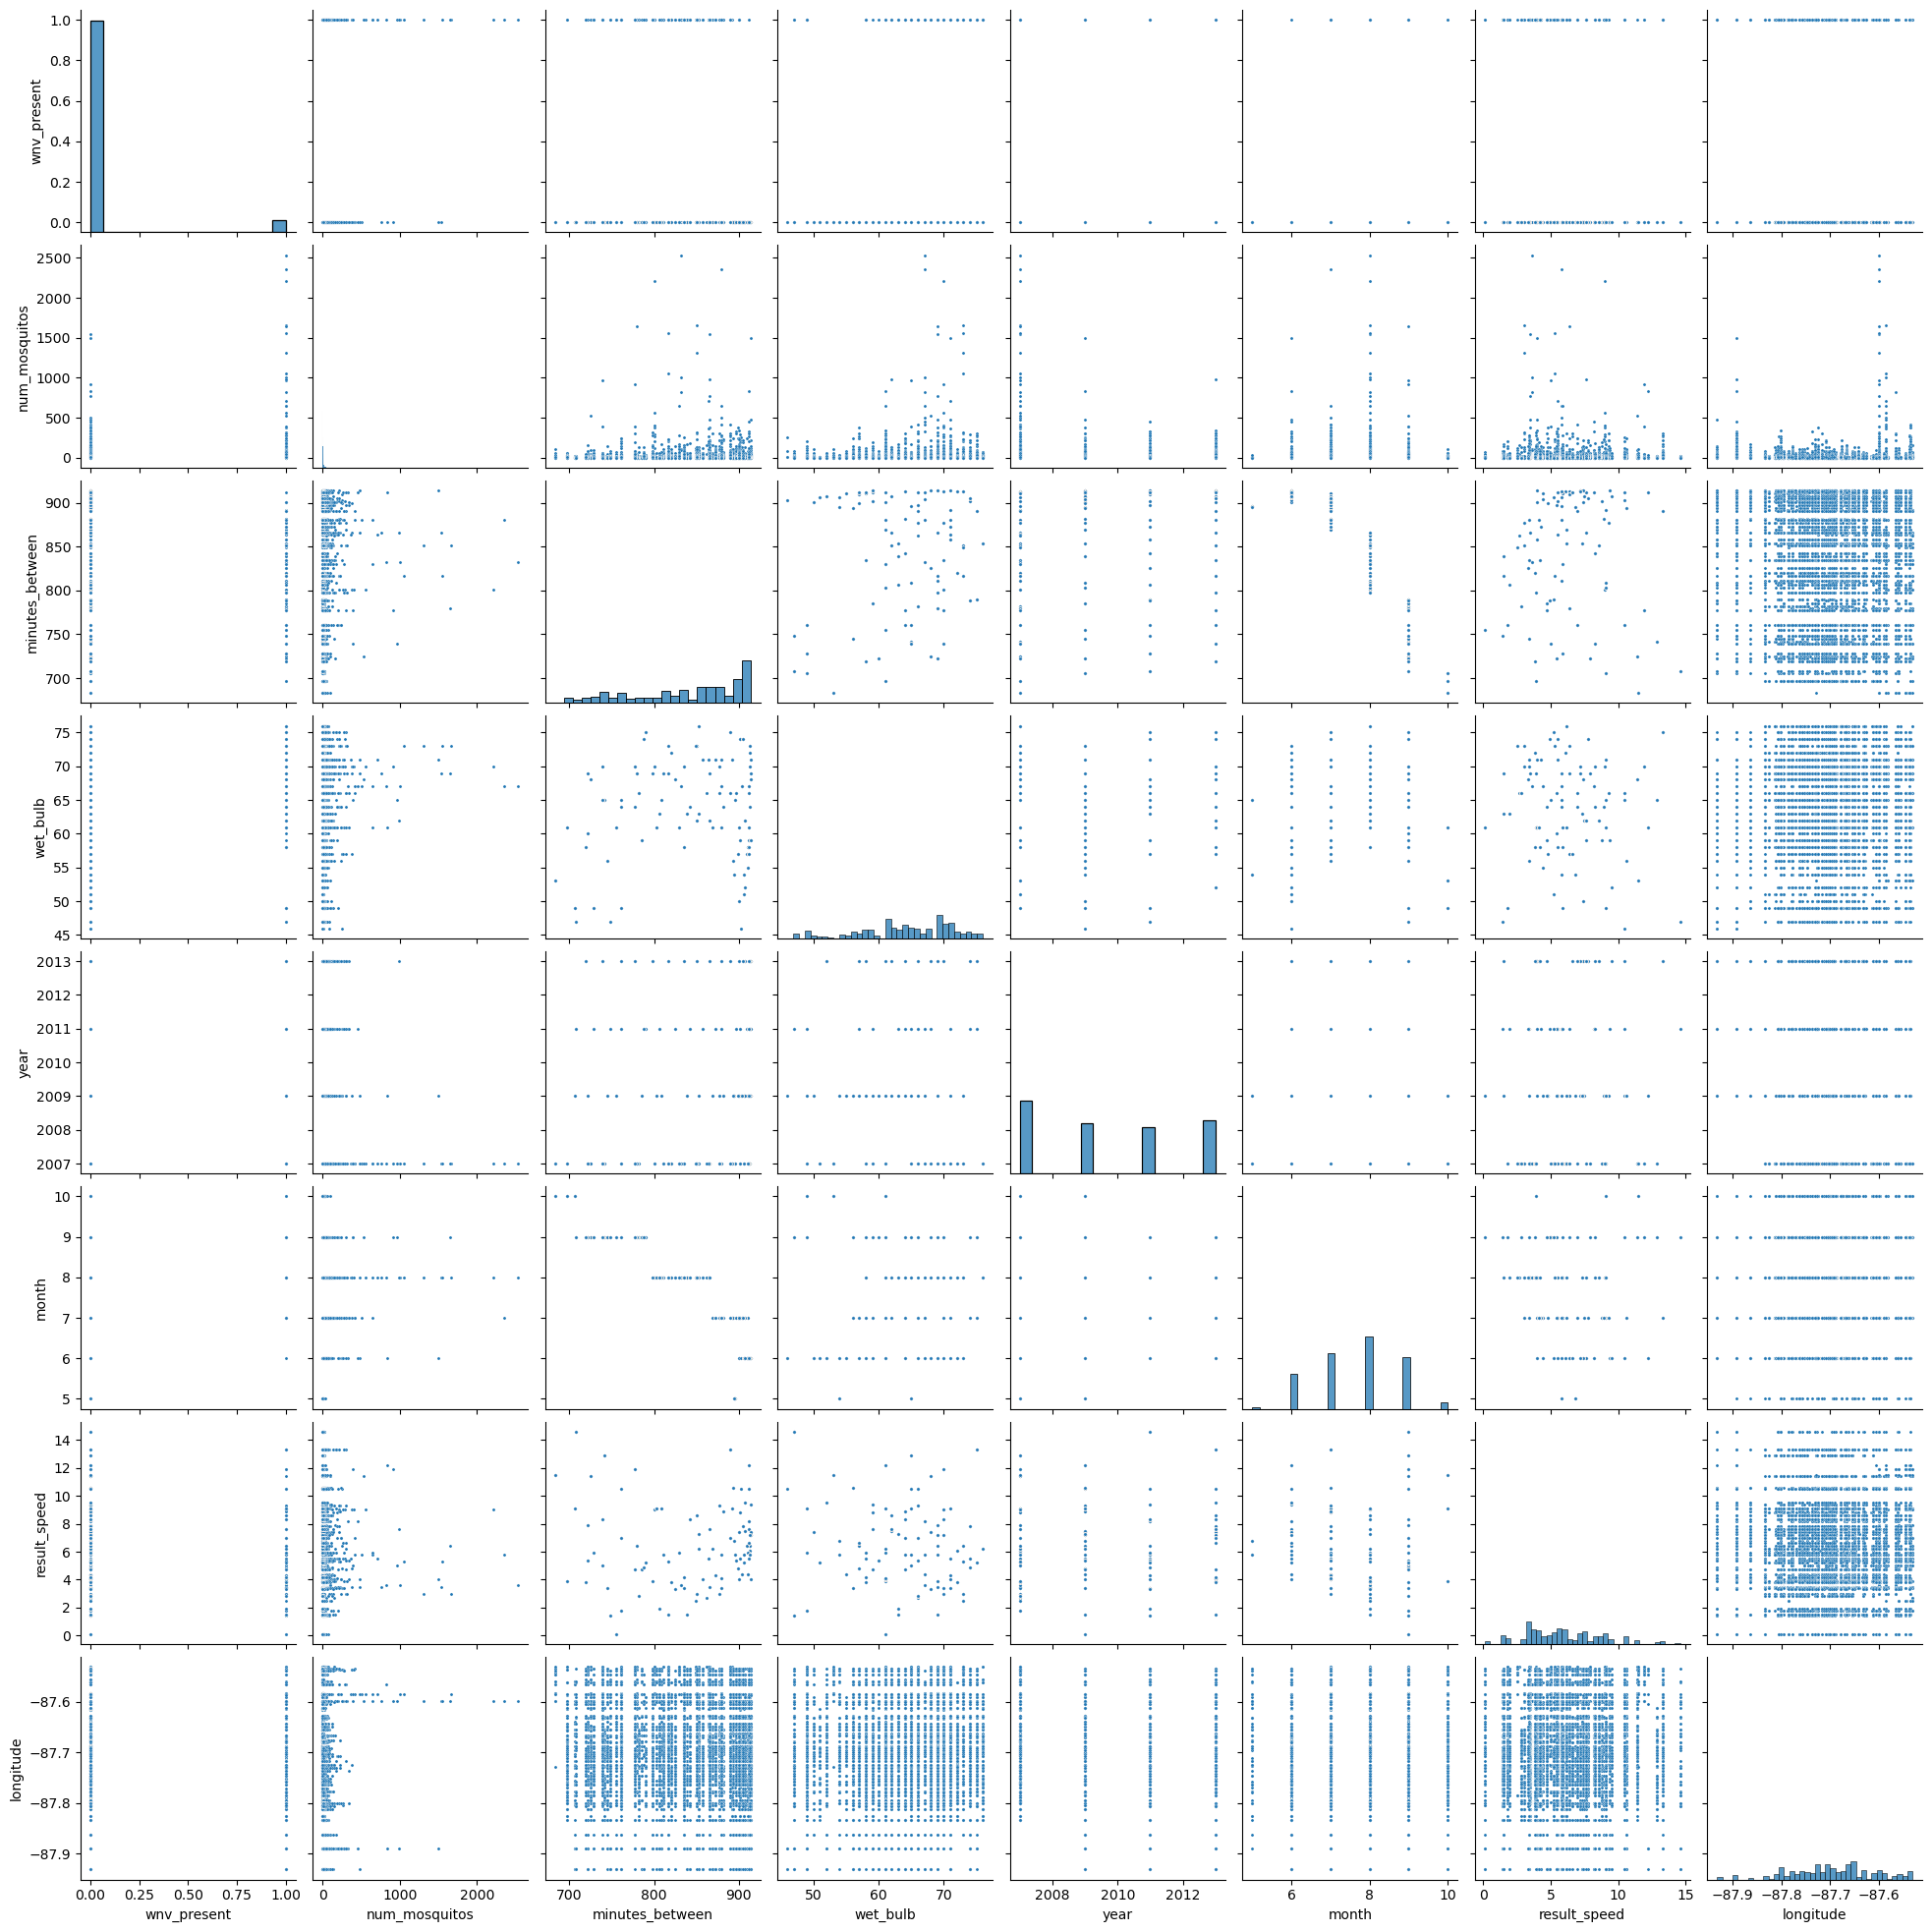

In [8]:
sns.pairplot(df_train[['wnv_present','num_mosquitos',
                               'minutes_between',
                               'wet_bulb',
                               'year', 'month',
                               'result_speed', 'longitude'
                   ]],
            plot_kws={'s': 5});

- More WNV present when temperature is higher. 
- High linear correlation between temperature features.

**Periods**

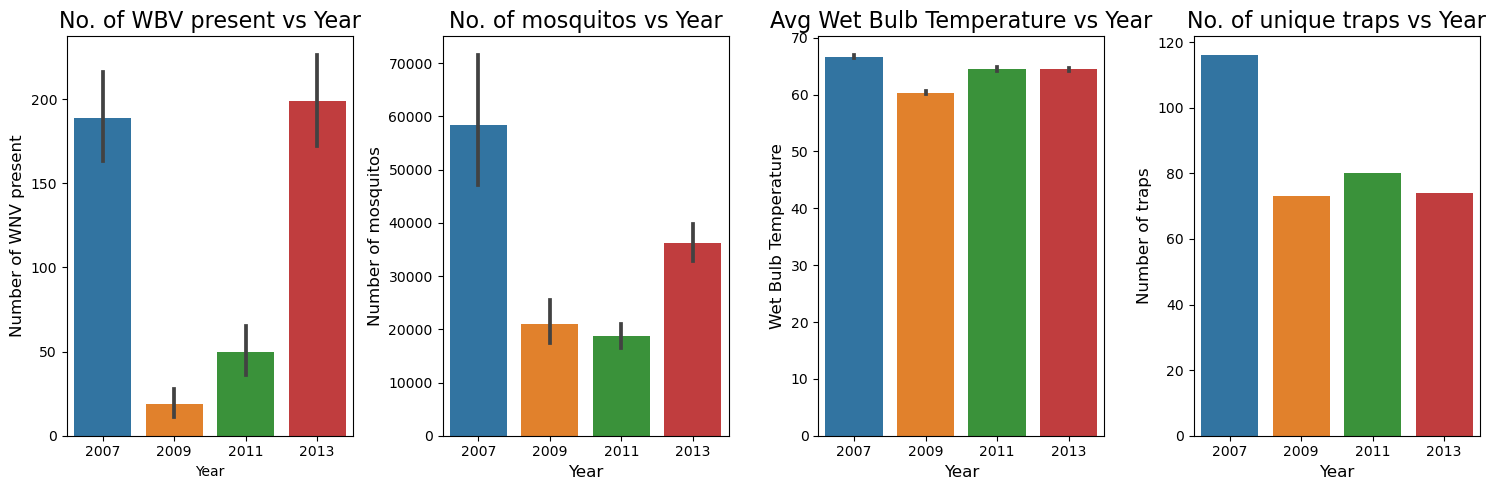

In [9]:
# Barplot to view relationship between columns

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5)) # Configure size and number of subplots 

sns.barplot(x='year', y='wnv_present', data=df_train, estimator=sum, ax=axs[0])
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of WNV present', fontsize=12)
axs[0].set_title('No. of WBV present vs Year', fontsize=16)

sns.barplot(x='year', y='num_mosquitos', data=df_train, estimator=sum, ax=axs[1])
axs[1].set_xlabel('Year', fontsize=12)
axs[1].set_ylabel('Number of mosquitos', fontsize=12)
axs[1].set_title('No. of mosquitos vs Year', fontsize=16)

sns.barplot(x='year', y='wet_bulb', data=df_train, ax=axs[2])
axs[2].set_xlabel('Year', fontsize=12)
axs[2].set_ylabel('Wet Bulb Temperature', fontsize=12)
axs[2].set_title('Avg Wet Bulb Temperature vs Year', fontsize=16)

trap_counts = df_train.groupby(['year'])['trap'].nunique().reset_index(name='count')
sns.barplot(x='year', y='count', data=trap_counts, estimator=sum, ax=axs[3])
axs[3].set_xlabel('Year', fontsize=12)
axs[3].set_ylabel('Number of traps', fontsize=12)
axs[3].set_title('No. of unique traps vs Year', fontsize=16)

plt.tight_layout() # Alignment such that no overlap for subplots

For train data, 
- there was significantly higher number of cases present in 2007 and 2013, aligned with the higher number of mosquitoes then. 
- wetbulb temperature was also highest in 2007. [Mosquitoes are most active at 80°F, become lethargic at 60°F, and cannot function below 50°F.](https://www.beyondpesticides.org/resources/mosquitos-and-insect-borne-diseases/documents/the-truth-about-mosquitoes,-pesticides-and-west-nile-virus). Thus the higher temperature in 2007 could be a contributing factor.
- higher number of mosquitoes and cases of WNV in 2007 could also be because there were more traps to collect these mosquitoes.
- the high number of west nile virus cases present in 2013. This cannot be explained by above graphs but will be explained later.

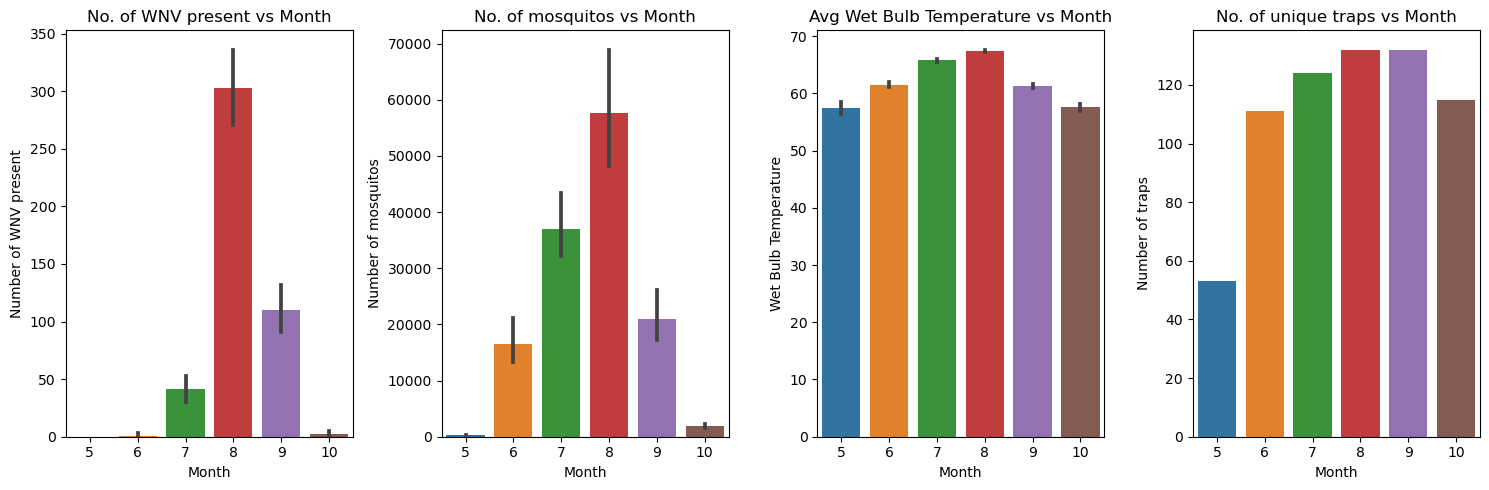

In [10]:
# Barplot to view relationship between columns

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5)) # Configure size and number of subplots 

sns.barplot(x='month', y='wnv_present', data=df_train, estimator=sum, ax=axs[0])
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of WNV present')
axs[0].set_title('No. of WNV present vs Month')

sns.barplot(x='month', y='num_mosquitos', data=df_train, estimator=sum, ax=axs[1])
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Number of mosquitos')
axs[1].set_title('No. of mosquitos vs Month')

sns.barplot(x='month', y='wet_bulb', data=df_train, ax=axs[2])
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Wet Bulb Temperature')
axs[2].set_title('Avg Wet Bulb Temperature vs Month')

trap_counts = df_train.groupby(['month'])['trap'].nunique().reset_index(name='count')
sns.barplot(x='month', y='count', data=trap_counts, estimator=sum, ax=axs[3])
axs[3].set_xlabel('Month')
axs[3].set_ylabel('Number of traps')
axs[3].set_title('No. of unique traps vs Month')

plt.tight_layout() # Alignment such that no overlap for subplots

Number of mosquitoes and WNV cases peak in Aug. That is where the is also the highest wet bulb temperature.

Most number of traps in Aug and Sep, corresponding to the peak.

##### Mosquito population by Species over Time

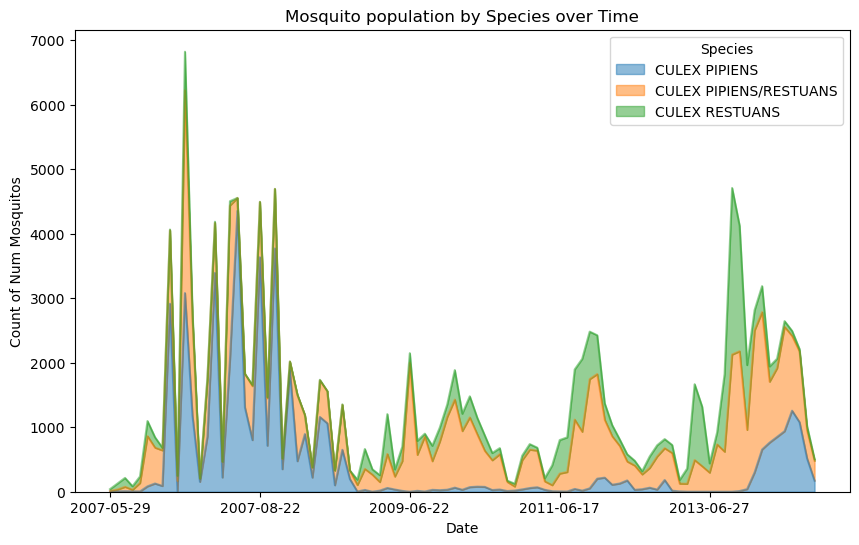

In [11]:
# Group the data by species and date and sum the number of mosquitoes in each group
counts = df_train.groupby(['species', 'date'])['num_mosquitos'].sum()

# Select the top 3 species by count
top_species = counts.groupby('species').sum().nlargest(3).index

# Filter the data to include only the top 3 species
counts = counts[counts.index.get_level_values('species').isin(top_species)]

# Reshape the data from long to wide format
counts = counts.unstack(level=0)

# Create a stacked area chart of the counts over time for each species
counts.plot(kind='area', stacked=True, alpha=0.5, figsize=(10, 6))

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Count of Num Mosquitos')
plt.title('Mosquito population by Species over Time')
plt.legend(title='Species')
plt.show()

There is consistent number of Culux Restuans each year. However in 2007 and 2013 where there are more Culux Pipiens as well, the number of WNV present is higher.

**Further investigation of periods (Average Monthly Temperature by Year)**

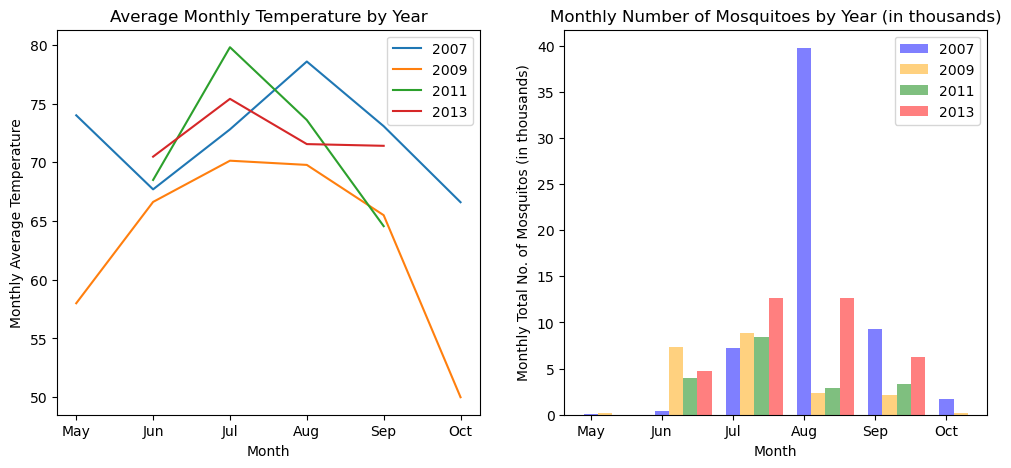

In [12]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Set 'date' column as the index
df_train = df_train.set_index('date')

# Compute the monthly mean temperature
monthly_tavg_mean = df_train['tavg'].groupby([df_train.index.year, df_train.index.month]).mean()

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the seasonal plot in the first subplot
ax = axs[0]
for year in monthly_tavg_mean.index.levels[0]:
    monthly_tavg_mean.loc[year].plot(ax=ax, label=year)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Average Temperature')
ax.set_title('Average Monthly Temperature by Year')
ax.legend(loc='upper right')
months = pd.date_range(start=df_train.index.min(), end=df_train.index.max(), freq='MS').strftime('%b')
ax.set_xticks(pd.date_range(start='2023-05-01', end='2023-10-31', freq='MS').month)
ax.set_xticklabels(['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

# Compute the monthly number of mosquitoes for four years
monthly_num_mosquitos = df_train.groupby([df_train.index.year, df_train.index.month])['num_mosquitos'].sum().unstack(level=0)

# Define a list of colors to use for the bar chart
colors = ['blue', 'orange', 'green', 'red']

# Plot the bar chart in the second subplot
ax = axs[1]
width = 0.2
for i, year in enumerate(monthly_num_mosquitos.columns):
    ax.bar(monthly_num_mosquitos.index + i * width, 
           monthly_num_mosquitos[year].values / 1000, 
           width, label=year, alpha=0.5, color=colors[i % len(colors)])

# Set the x-axis label for the bar chart
ax.set_xlabel('Month')

# Set the y-axis label for the temperature and mosquitoes
ax.set_ylabel('Monthly Total No. of Mosquitos (in thousands)')

# Set the title for the bar chart
ax.set_title('Monthly Number of Mosquitoes by Year (in thousands)')

# Add legend to the bar chart
ax.legend(loc='upper right')
months = pd.date_range(start=df_train.index.min(), end=df_train.index.max(), freq='MS').strftime('%b')
ax.set_xticks(pd.date_range(start='2023-05-01', end='2023-10-31', freq='MS').month)
ax.set_xticklabels(['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

# Show the plot
plt.show()

The correlation between temperature and number of mosquitoes can be best observed in 2007. During the months of June to August, there was a notable increase in the number of mosquitoes as the temperature rose. However, as the temperature began to decrease in September and October, the mosquito population began to decline as well. This correlation highlights the significance of temperature in influencing mosquito activity and can provide valuable insights for mosquito control efforts.

**Species**

In [13]:
species = df_train[['species', 'num_mosquitos', 'wnv_present']].groupby('species').sum()
species = species.sort_values(by='wnv_present', ascending=False)
species

num_mosquitos  wnv_present
species                                           
CULEX PIPIENS/RESTUANS          65841          225
CULEX PIPIENS                   44488          184
CULEX RESTUANS                  23326           48
CULEX ERRATICUS                     7            0
CULEX SALINARIUS                  144            0
CULEX TARSALIS                      7            0
CULEX TERRITANS                   508            0

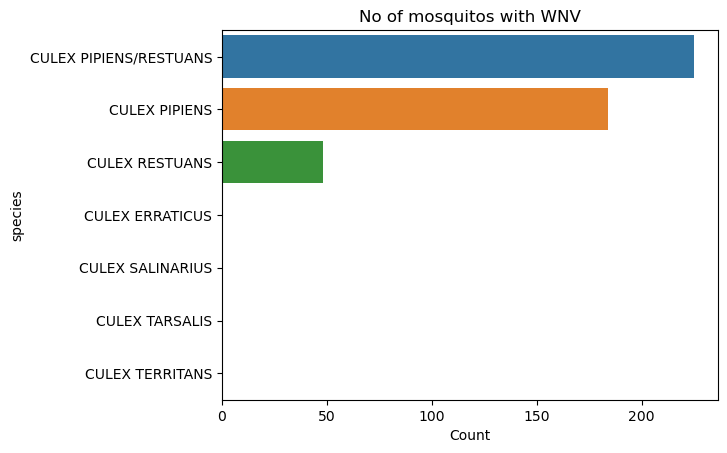

In [14]:
sns.barplot(data=species, y=species.index, x=species['wnv_present'], orient='h')
plt.title('No of mosquitos with WNV')
plt.xlabel('Count');

Most of the mosquito species in our data is either Culex Pipiens / Culex Restuans or a hybrid/combination of both. These are the only 2 species that carry the WNV unlike the 4 less common species.

#### Distribution of Infected / Non-infected Mosquitoes by Species

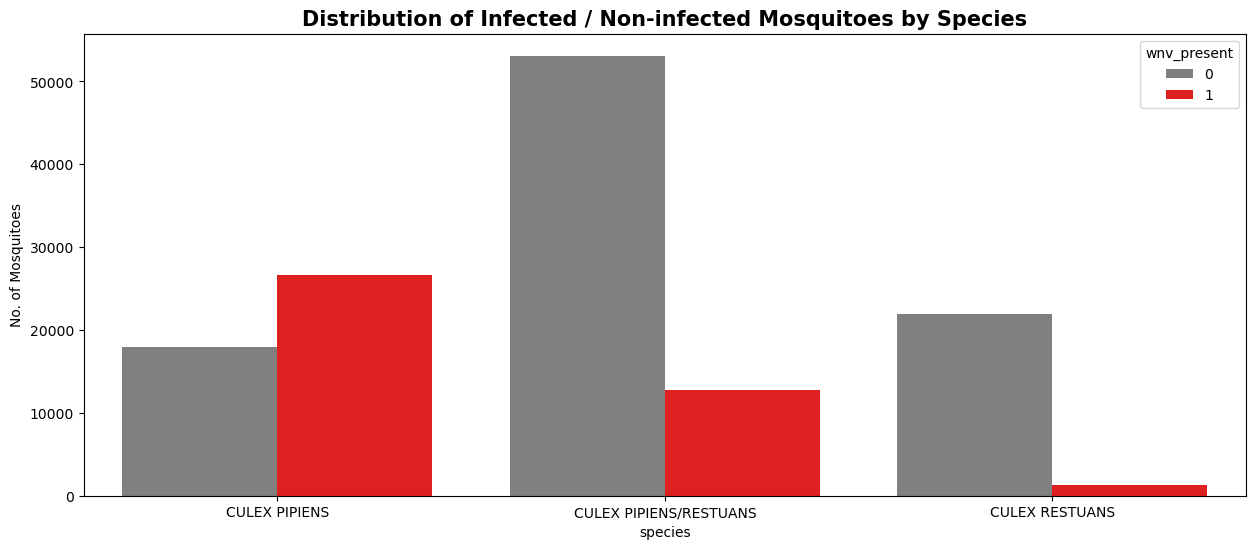

In [15]:
plt.figure(figsize =(15,6))
data = df_train.groupby(['species', 'wnv_present'])['num_mosquitos'].sum().reset_index()
data = data[data['species'].isin(data.groupby('species')['num_mosquitos'].sum().nlargest(3).index)]
data = data.sort_values(['species', 'wnv_present'], ascending=[True, False])
sns.barplot(data=data, x='species', y='num_mosquitos', hue='wnv_present', palette={0:'gray', 1:'red'})
plt.title("Distribution of Infected / Non-infected Mosquitoes by Species", fontsize = 15, fontweight='bold')
plt.ylabel("No. of Mosquitoes");

The Culux Pipiens has a higher ratio of WNV present compared to Culux Restuans.

**Traps**

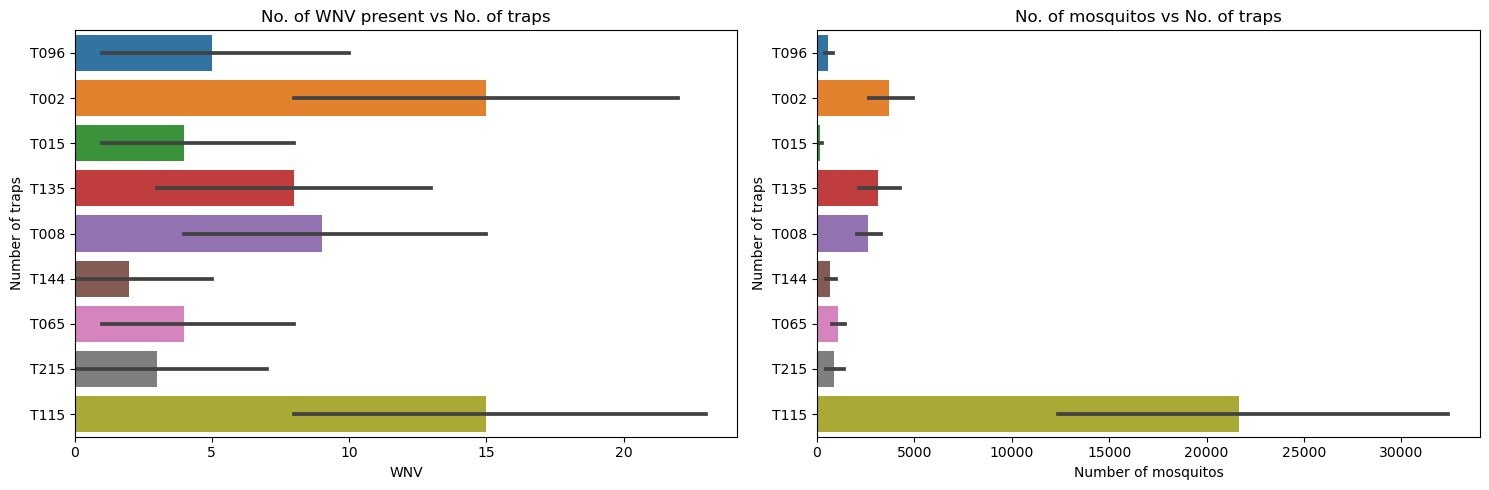

In [16]:
# Barplot to view relationship between columns

wnv_top_10_traps = df_train.nlargest(10, 'wnv_present')['trap'].unique()
df_wnv_top_10 = df_train[df_train['trap'].isin(wnv_top_10_traps)]

mosq_top_10_traps = df_train.nlargest(10, 'num_mosquitos')['trap'].unique()
df_mosq_top_10 = df_train[df_train['trap'].isin(wnv_top_10_traps)]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)) # Configure size and number of subplots 

sns.barplot(x='wnv_present', y='trap', data=df_wnv_top_10, estimator=sum, ax=axs[0])
axs[0].set_xlabel('WNV')
axs[0].set_ylabel('Number of traps')
axs[0].set_title('No. of WNV present vs No. of traps')

sns.barplot(x='num_mosquitos', y='trap', data=df_mosq_top_10, estimator=sum, ax=axs[1])
axs[1].set_xlabel('Number of mosquitos')
axs[1].set_ylabel('Number of traps')
axs[1].set_title('No. of mosquitos vs No. of traps')

plt.tight_layout();

Two traps have much higher number of cases: <br>
Trap T115: At 1200  S DOTY AVE, Chicago, IL, which is near 2 bodies of water. Mosquitoes thrive where there is [standing or slow-moving water](https://www.beyondpesticides.org/resources/mosquitos-and-insect-borne-diseases/documents/the-truth-about-mosquitoes,-pesticides-and-west-nile-virus). <br>
Trap T002: At 4100  N OAK PARK AVE, Chicago, IL which is near O'Hare International Airport. It could be a suitable environment for mosquito breeding.

**Barplots of various features**

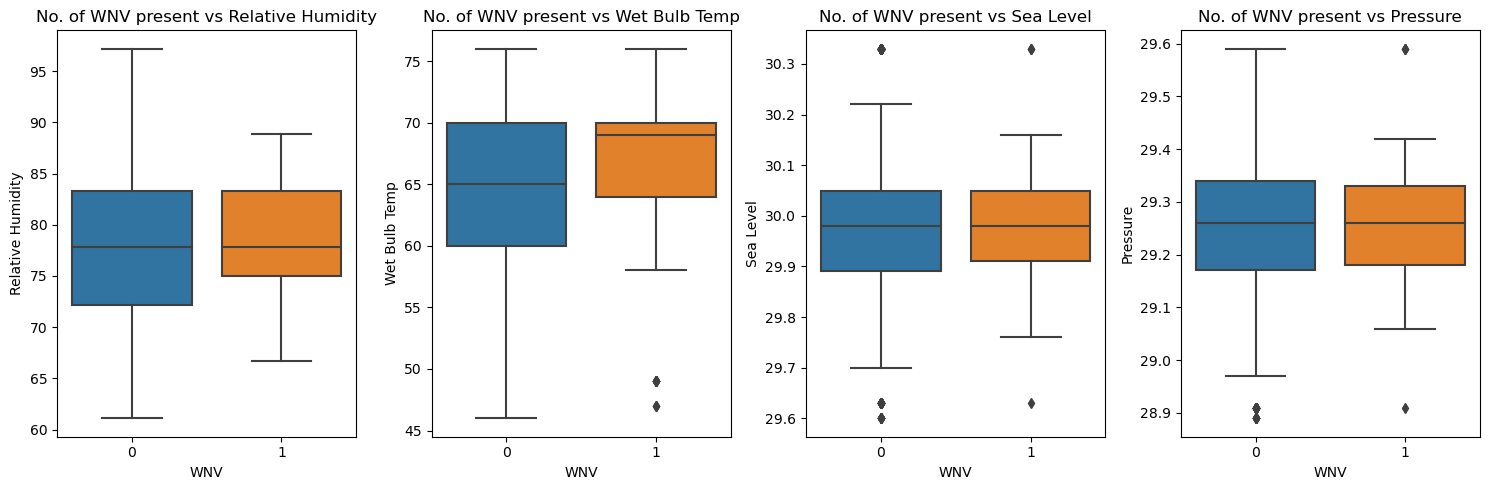

In [17]:
# Barplot to view relationship between columns

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5)) # Configure size and number of subplots 

sns.boxplot(x='wnv_present', y='relative_humidity', data=df_train, ax=axs[0])
axs[0].set_xlabel('WNV')
axs[0].set_ylabel('Relative Humidity')
axs[0].set_title('No. of WNV present vs Relative Humidity')

sns.boxplot(x='wnv_present', y='wet_bulb', data=df_train, ax=axs[1])
axs[1].set_xlabel('WNV')
axs[1].set_ylabel('Wet Bulb Temp')
axs[1].set_title('No. of WNV present vs Wet Bulb Temp')

sns.boxplot(x='wnv_present', y='sea_level', data=df_train, ax=axs[2])
axs[2].set_xlabel('WNV')
axs[2].set_ylabel('Sea Level')
axs[2].set_title('No. of WNV present vs Sea Level')

sns.boxplot(x='wnv_present', y='stn_pressure', data=df_train, ax=axs[3])
axs[3].set_xlabel('WNV')
axs[3].set_ylabel('Pressure')
axs[3].set_title('No. of WNV present vs Pressure')

plt.tight_layout()

Higher temperature means more WNV cases. As mentioned, mosquitoes thrive at higher temperatures.

Relative Humidity, Sea Level and Pressure have no impact to WNV cases.

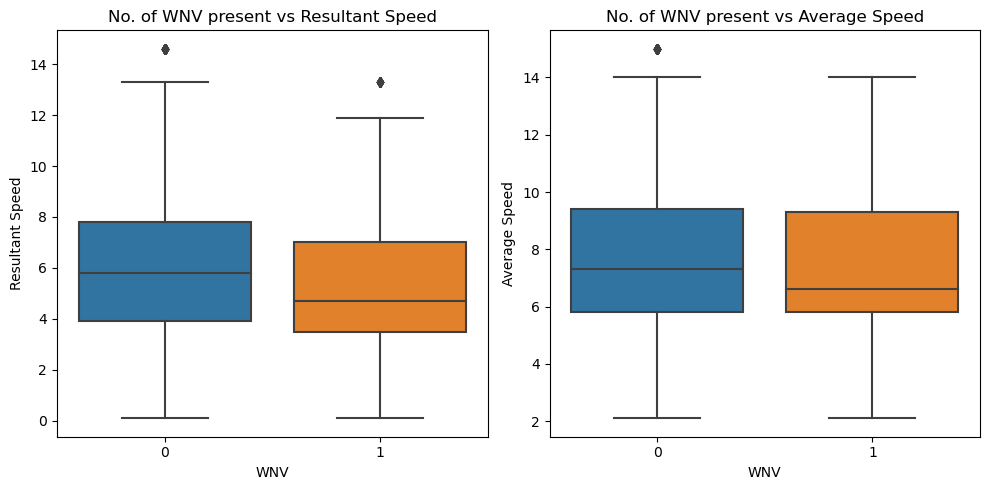

In [18]:
# Barplot to view relationship between columns

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # Configure size and number of subplots 

sns.boxplot(x='wnv_present', y='result_speed', data=df_train, ax=axs[0])
axs[0].set_xlabel('WNV')
axs[0].set_ylabel('Resultant Speed')
axs[0].set_title('No. of WNV present vs Resultant Speed')

sns.boxplot(x='wnv_present', y='avg_speed', data=df_train, ax=axs[1])
axs[1].set_xlabel('WNV')
axs[1].set_ylabel('Average Speed')
axs[1].set_title('No. of WNV present vs Average Speed')

plt.tight_layout()

Lower wind speed means more WNV. This is because [mosquitoes are generally are not strong flyers](https://www.orkin.com/pests/mosquitoes/when-are-mosquitoes-most-active).

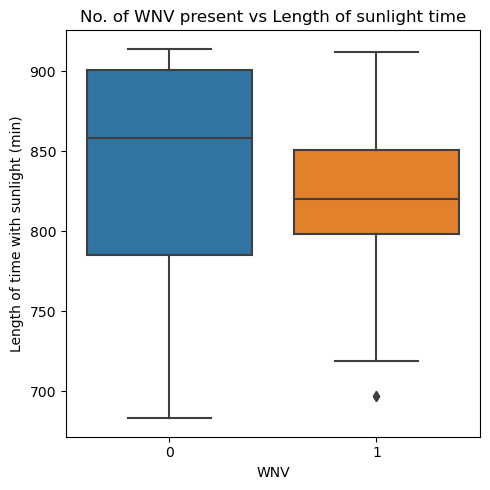

In [19]:
# Barplot to view relationship between columns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5)) # Configure size and number of subplots 

sns.boxplot(x='wnv_present', y='minutes_between', data=df_train, ax=ax)
ax.set_xlabel('WNV')
ax.set_ylabel('Length of time with sunlight (min)')
ax.set_title('No. of WNV present vs Length of sunlight time')

plt.tight_layout()

Less sunlight duration means more cases. This could be because the [Culux Pipiens is normally active at night](https://www.mosquitomagnet.com/advice/mosquito-info/biting-insect-library/culex-pipiens-mosquito).

#### Top 20 Infected Locations

In [20]:
location_wnv = df_train.groupby('address_number_and_street').mean().reset_index()[['address_number_and_street', 'wnv_present']]
location_wnv2 = df_train.groupby('address_number_and_street').sum().reset_index()[['address_number_and_street', 'num_mosquitos']]
location_wnv_merged = pd.merge(location_wnv, location_wnv2, on='address_number_and_street').sort_values('wnv_present', ascending= False).head(20)

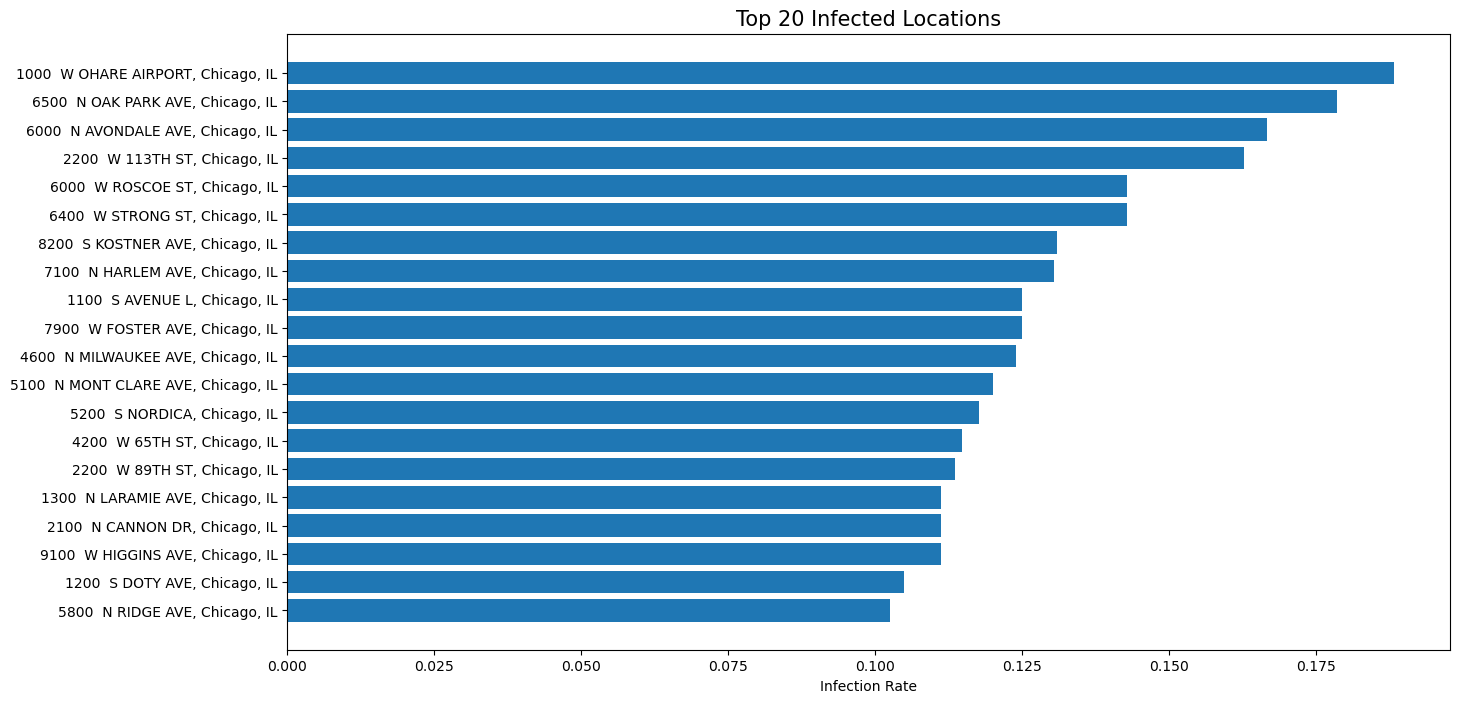

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

# sort 'wnv_present' column in descending order
location_wnv_merged.sort_values(by='wnv_present', ascending=False, inplace=True)

ax.barh(location_wnv_merged['address_number_and_street'], location_wnv_merged['wnv_present'])
ax.invert_yaxis()
ax.set_xlabel('Infection Rate')
ax.set_title('Top 20 Infected Locations', size=15)
plt.show()

Ohare Airport is the top infected locations. Many of the top 20 infected locations are also located west of Ohare Airport.

In [22]:
# creating columns for month and year in the spray data to make it easier to plot
df_spray['date'] = pd.to_datetime(df_spray['date'])
df_spray['month'] = df_spray['date'].dt.month
df_spray['year'] = df_spray['date'].dt.year

**Location of Traps and WNV Present by Year for the months of Jul to Sep**

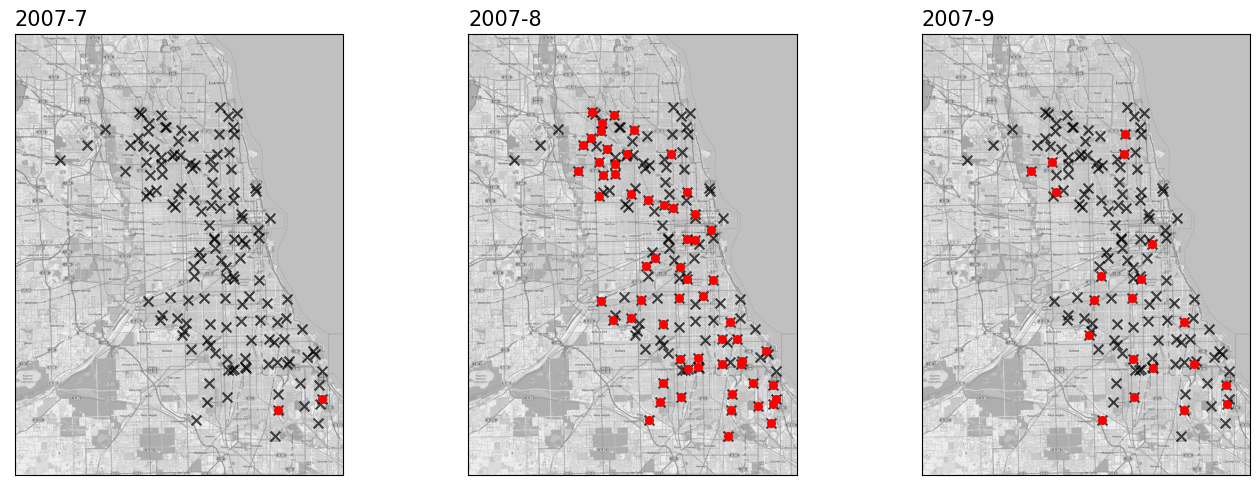

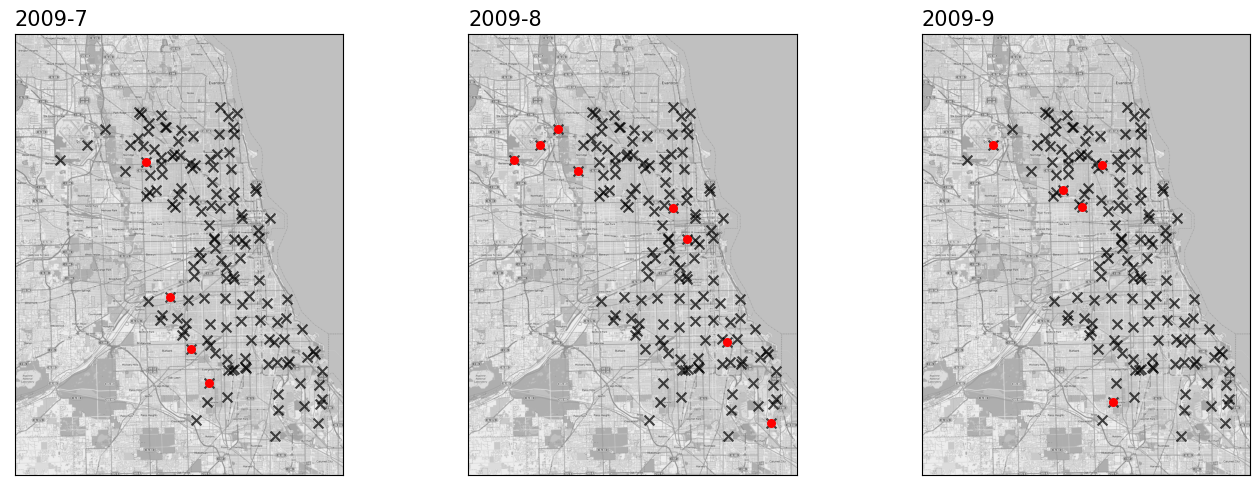

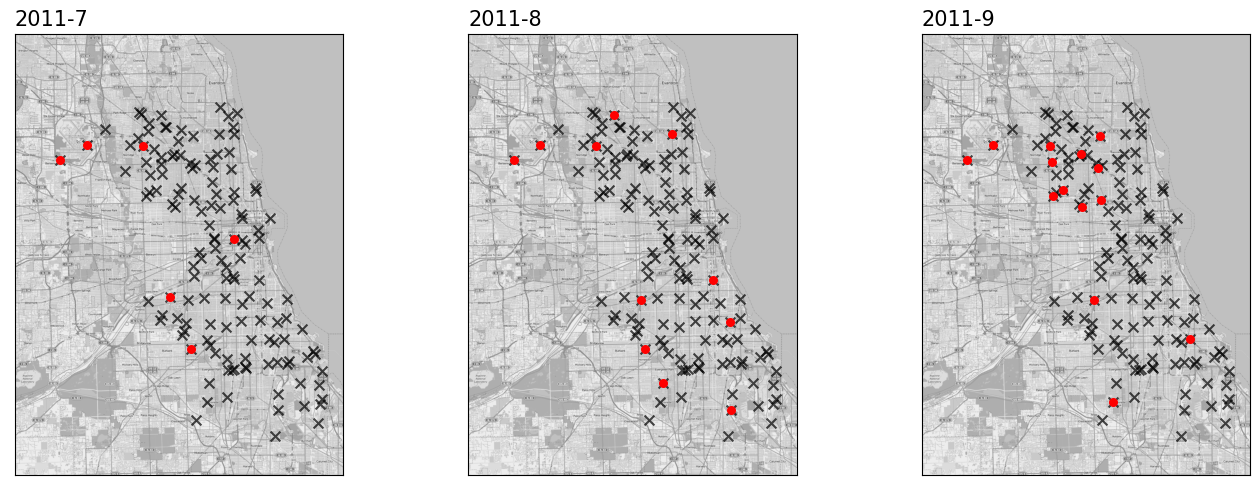

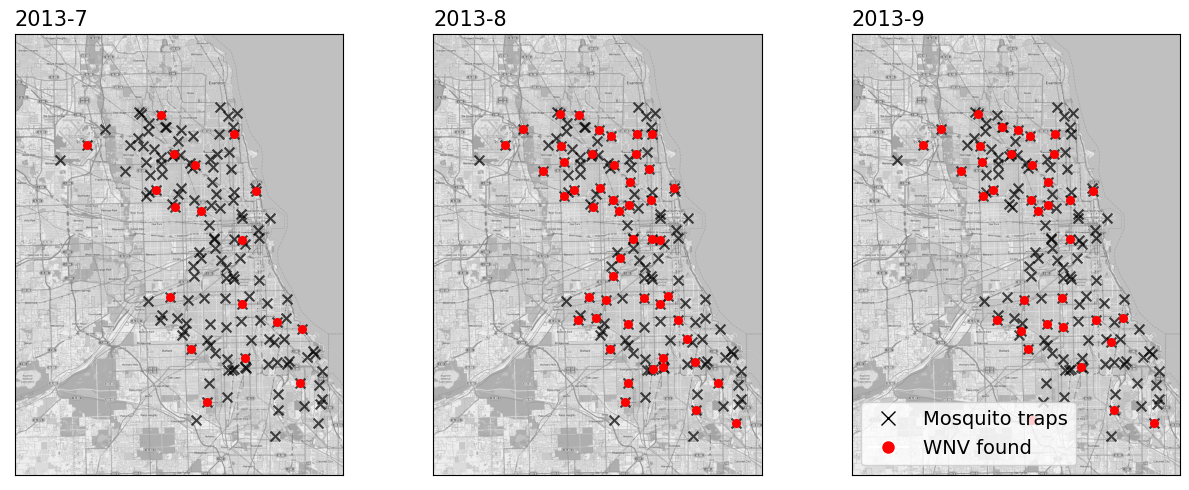

In [23]:
# set up basemap
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
for year in df_train.year.unique():
    fig, ax = plt.subplots(ncols = 3, figsize = (16,5))
    
    for i, month in enumerate([7,8,9]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
                   
        # plot trap locations
        locations = df_train[['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations for year and month
        wnv = df_train[(df_train.year == year) & (df_train.month == month) & (df_train.wnv_present == 1)]\
                [['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'red', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='x', color='black', label='Mosquito traps',linestyle='', markersize=10),
                 Line2D([0],[0],marker='o', color='w',label='WNV found',markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='lower left', fontsize=14)
plt.tight_layout()

We plot the location of mosquito traps and WNV presence found for the months of Jul to Sep. We noted that the number of WNV present in mosquitoes vary from year to year. In most years, it peaks in August.

Across all 4 years, the presence of WNV seems to be randomly scattered across most of Chicago. 

The small noticable patterns would be in 2007, across the months of July, August and September, there were counts of WNV presence in the South East. In 2009, it was pretty evenly spread out but mainly in the North West and South East of the map. In 2011, presence was also equally split between North West and South East. 2013 shows quite an even spread of WNV presence throughout Chicago.

The density map below show clearer the distribution by locations.

**Location of Spray and WNV Present by Year for the months of Jul to Sep**

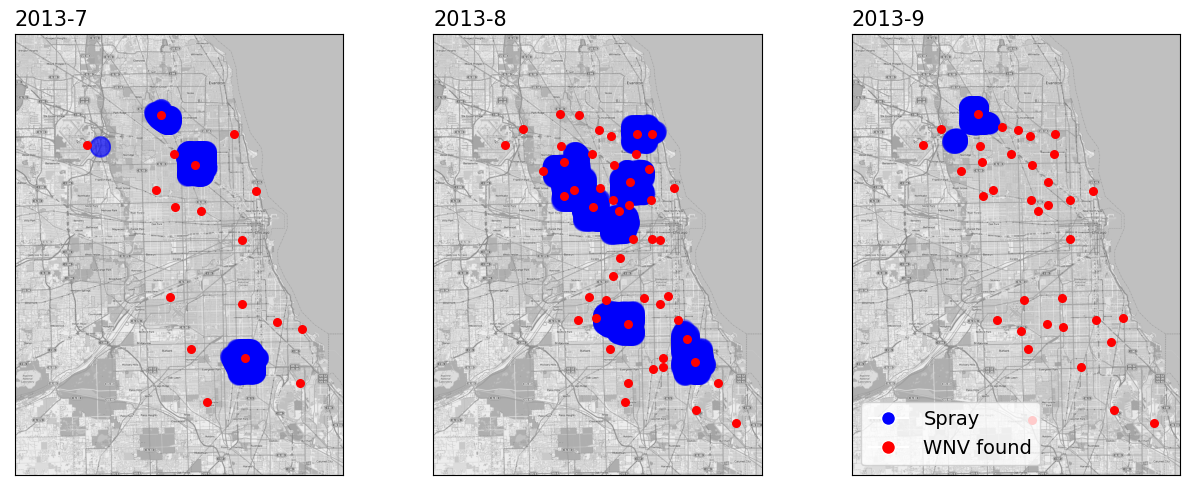

In [24]:
# set up basemap
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
if year in (df_spray['year'] == 2013):
    fig, ax = plt.subplots(ncols = 3, figsize = (16,5))
    
    for i, month in enumerate([7,8,9]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # plot spray locations for year and month
        if year in df_spray.year.unique() and month in df_spray.month.unique():
            spray_location = df_spray[(df_spray.year == year) & (df_spray.month == month)][['longitude', 'latitude']].drop_duplicates().values
            ax[i].scatter(spray_location[:,0], spray_location[:,1], marker='o', c = 'blue', s = 200, alpha = 0.2)
        
        
        # plot wnv locations for year and month
        wnv = df_train[(df_train.year == year) & (df_train.month == month) & (df_train.wnv_present == 1)]\
                [['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'red', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='o', color='w',label='Spray', markerfacecolor='blue', markersize=10),
                Line2D([0],[0],marker='o', color='w',label='WNV found',markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='lower left', fontsize=14)
plt.tight_layout()

There is limited spray data provided. For example, there is no spray data for some years while the spray coordinates in August of 2011 is outside of the Chicago map boundaries. As such, we only plot for Jul to Sep 2013 where there is sufficient information.

We note that in 2013 there was most spraying in Aug where there were more WNV present as well. However, there is not enough data to conclusively evaluate the efficacy of the spraying and the effect it had on WNV presence.

**Location of Spray and WNV Present by Year for the months of Jul to Sep (more than 30 mosquitoes only)**

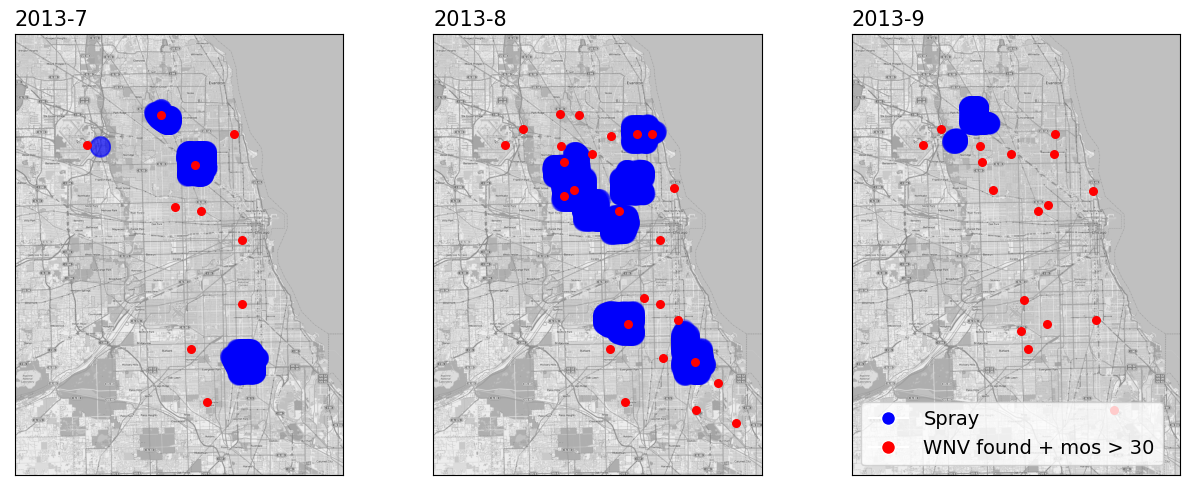

In [25]:
# set up basemap
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
if year in (df_spray['year'] == 2013):
    fig, ax = plt.subplots(ncols = 3, figsize = (16,5))
    
    for i, month in enumerate([7,8,9]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # plot spray locations for year and month
        if year in df_spray.year.unique() and month in df_spray.month.unique():
            spray_location = df_spray[(df_spray.year == year) & (df_spray.month == month)][['longitude', 'latitude']].drop_duplicates().values
            ax[i].scatter(spray_location[:,0], spray_location[:,1], marker='o', c = 'blue', s = 200, alpha = 0.2)
        
        
        wnv_num_mos = df_train[(df_train.year == year) & (df_train.month == month) & (df_train.wnv_present == 1) & (df_train.num_mosquitos >= 30)]\
                [['longitude', 'latitude']].drop_duplicates().values
               
        # plot wnv locations with more than 30 mosquitoes for year and month
        ax[i].scatter(wnv_num_mos[:,0], wnv_num_mos[:,1], marker='o', c = 'red', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='o', color='w',label='Spray', markerfacecolor='blue', markersize=10),
                Line2D([0],[0],marker='o', color='w',label='WNV found + mos > 30',markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='lower left', fontsize=14)
plt.tight_layout()

We reduced the plots to only include WNV found where there are more than 30 mosquitoes only. We also plotted the areas which were sprayed in 2013.

We noted that number of cases (the red spots) decreased in Sep. This could be because the spraying (done more extensively in Aug) can was effective in reducing the mosquito population in the area, but could be better timed and targeted to increase effectiveness. Alternatively, it could just be that the number of mosquitoes decreased naturally after the peak in Aug.

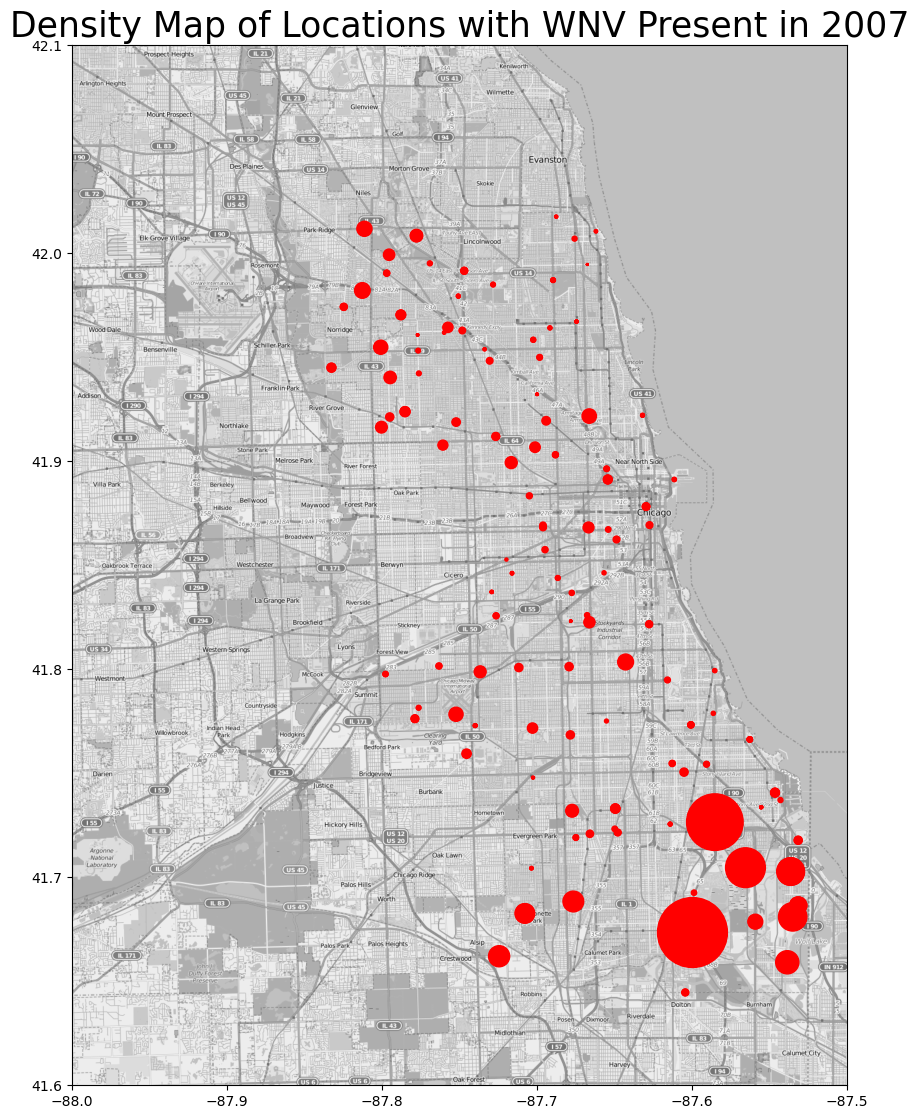

In [26]:
# Plot WNV trap locations in 2007
plt.figure(figsize=(10,15))
plt.imshow(mapdata,
           cmap=plt.get_cmap("gray"),
           extent=lon_lat_box,
           aspect=aspect)

# Plotting locations where WNV was detected
wnv_loc2007 = df_train.loc[df_train['year'] == 2007]
plt.scatter(wnv_loc2007["longitude"], wnv_loc2007["latitude"], marker='o',
            c='red', s=wnv_loc2007["num_mosquitos"], label='WNV Detected')
plt.title('Density Map of Locations with WNV Present in 2007', fontsize=25);

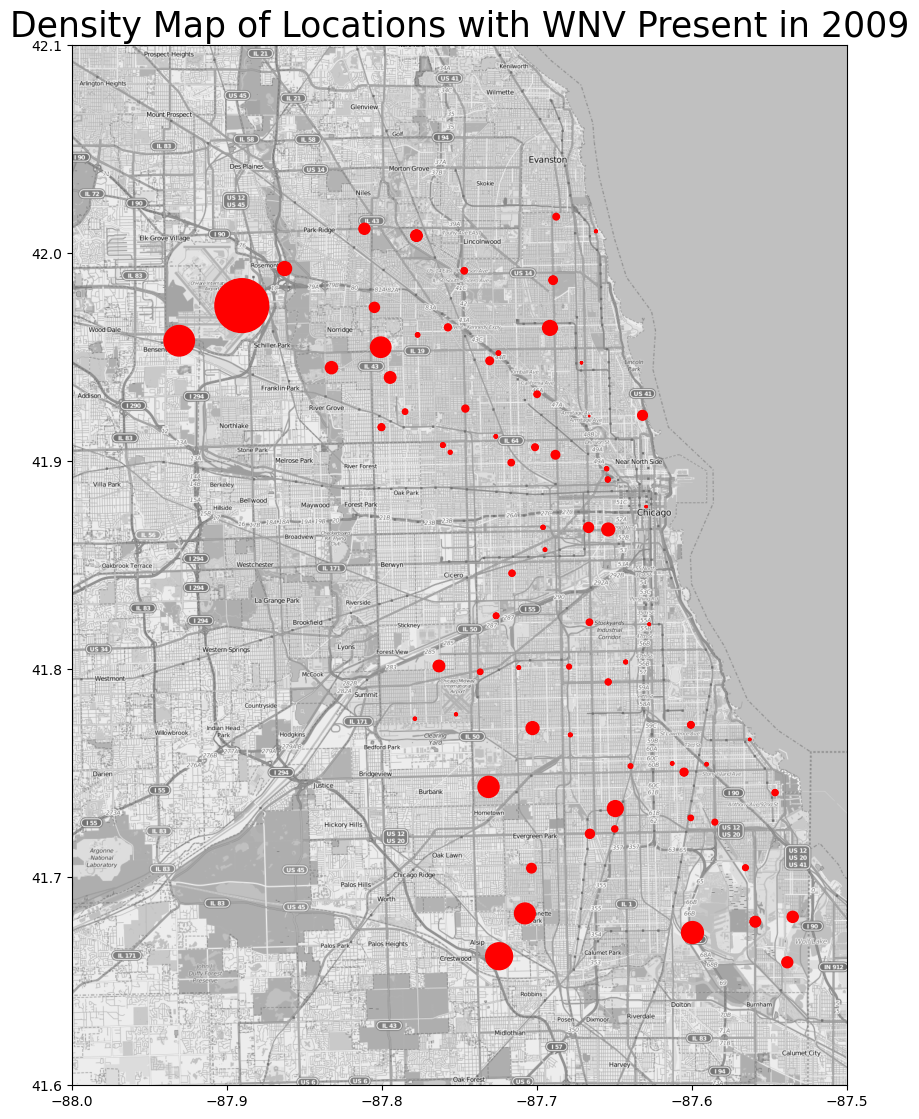

In [27]:
# Plot WNV trap locations in 2009
plt.figure(figsize=(10,15))
plt.imshow(mapdata,
           cmap=plt.get_cmap("gray"),
           extent=lon_lat_box,
           aspect=aspect)

# Plotting locations where WNV was detected
wnv_loc2009 = df_train.loc[df_train['year'] == 2009]
plt.scatter(wnv_loc2009["longitude"], wnv_loc2009["latitude"], marker='o',
            c='red', s=wnv_loc2009["num_mosquitos"], label='WNV Detected')
plt.title('Density Map of Locations with WNV Present in 2009', fontsize=25);

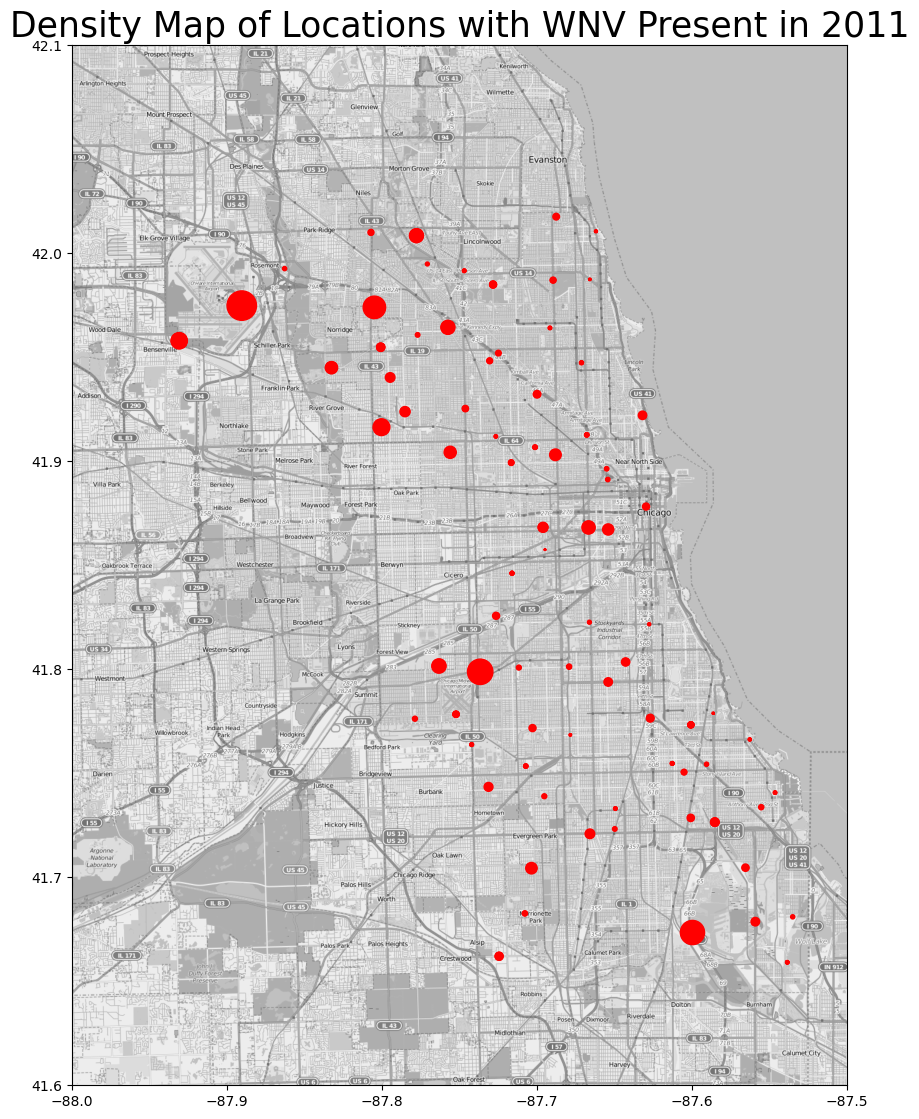

In [28]:
# Plot WNV trap locations in 2011
plt.figure(figsize=(10,15))
plt.imshow(mapdata,
           cmap=plt.get_cmap("gray"),
           extent=lon_lat_box,
           aspect=aspect)

# Plotting locations where WNV was detected
wnv_loc2011 = df_train.loc[df_train['year'] == 2011]
plt.scatter(wnv_loc2011["longitude"], wnv_loc2011["latitude"], marker='o',
            c='red', s=wnv_loc2011["num_mosquitos"], label='WNV Detected')
plt.title('Density Map of Locations with WNV Present in 2011', fontsize=25);

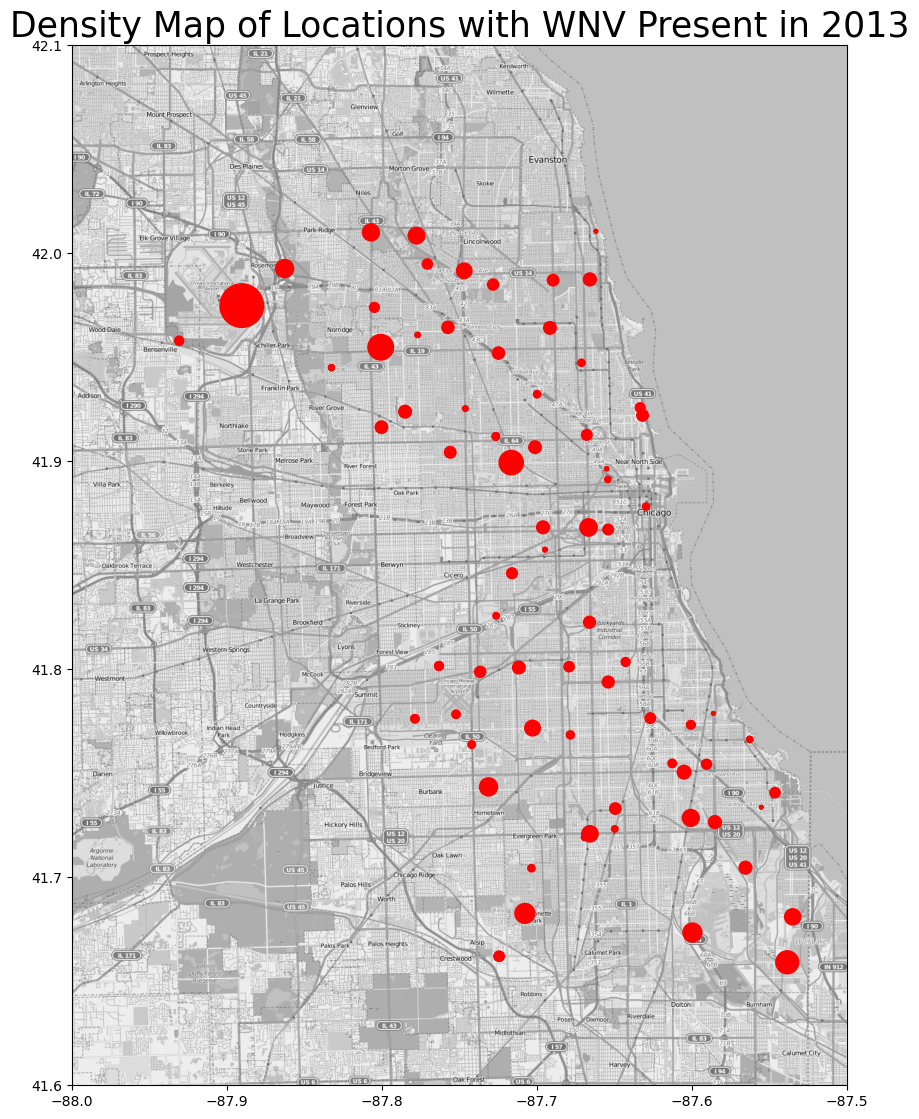

In [29]:
# Plot WNV trap locations in 2013
plt.figure(figsize=(10,15))
plt.imshow(mapdata,
           cmap=plt.get_cmap("gray"),
           extent=lon_lat_box,
           aspect=aspect)

# Plotting locations where WNV was detected
wnv_loc2013 = df_train.loc[df_train['year'] == 2013]
plt.scatter(wnv_loc2013["longitude"], wnv_loc2013["latitude"], marker='o',
            c='red', s=wnv_loc2013["num_mosquitos"], label='WNV Detected')
plt.title('Density Map of Locations with WNV Present in 2013', fontsize=25);

From the plots above where WNV presence was plotted by intensity, the presence seems to be scattered throughout different locations in the city, with unusually big clusters in the North-West (where Ohare Airport is) and South-East regions (where there are two bodies of water: Lake Camulet and Wolf Lake). 

Different areas have high number of cases in different years. The big cluster in 2007 was in the South-East region while the big cluster in 2009, 2011 and 2013 were near the airport.

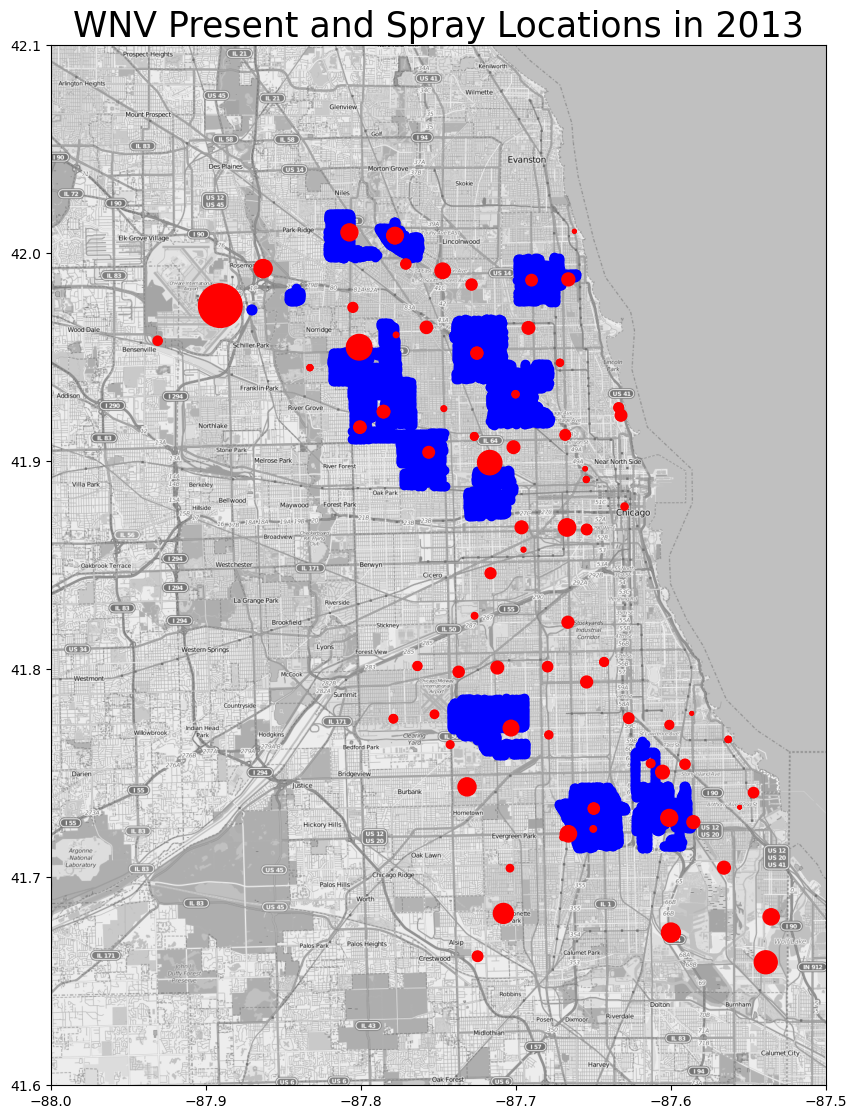

In [30]:
# Set up map
plt.figure(figsize=(10,15))
plt.imshow(mapdata,
           cmap=plt.get_cmap("gray"),
           extent=lon_lat_box,
           aspect=aspect)

# Plotting locations where WNV was detected
wnv_loc2013 = df_train.loc[df_train['year'] == 2013]
spray_loc = df_spray.loc[df_spray['year'] == 2013]

plt.scatter(spray_loc["longitude"], spray_loc["latitude"], marker='o',
            c='blue', label='WNV Detected')
plt.scatter(wnv_loc2013["longitude"], wnv_loc2013["latitude"], marker='o',
            c='red', s=wnv_loc2013["num_mosquitos"], label='Spray')

plt.title('WNV Present and Spray Locations in 2013', fontsize=25);

Similar to the first observations on spray data above, most of the concentration seems to be in 2 broad range hot spots in the North West and the South East. The spray areas do not necessarily cover all areas with WNV presence.

---
## Summary
---

Main features with higher correlation are:
- Temperature. Mosquitoes tend to to become lethargic below 60°F
- Species. Only certain species carry WNV (Culux Pipiens and Culux Restuans. Culux Pipiens has a higher probability of being carriers.)
- Daylight duration. Culux Pipiens is normally active at night in homes.
- Wind speed. Mosquitoes are not good at flying and will be affected by winds
- Period of the year. In certain months/weeks, there are higher mosquito population and number of WNV present.
- Location. Areas near the airport and near water sources are likely to be better environments for mosquitoes to thrive. Locations with high number of cases vary from year to year.

Effects of spraying:
- there is limited data on spraying by location
- based on the limited data, targetted spraying could increase the coverage. We will explore modelling to predict the areas to spray (Part 3) as well as the cost-benefit of varying levels of spraying (Part 4).